In [81]:
import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

#### PLOT THE DATA #######
textwidth_cm = 16.50764  # Text width in cm
aspect_ratio = 0.618     # Aspect ratio (height/width) using the golden ratio

# Font sizes
label_fontsize = 10
legend_fontsize = 10
tick_fontsize = 8
colorbar_label_fontsize = 10
colorbar_tick_fontsize = 8
offset_text_fontsize = 8

# Convert text width from cm to inches
textwidth_in = textwidth_cm / 2.54

# Calculate figure size based on text width and aspect ratio
fig_width = textwidth_in
fig_height = textwidth_in * aspect_ratio

In [82]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


# beta_rel = 0.305
beta_rel = 0.106

# gamma = 1.050
gamma = 1.006


current=0.4
cooler_length = 1.5 # m cooler length
radius_e_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

temp_perp = 0.01 # <E> [eV] = kb*T
temp_long =  0.001 # <E> [eV]
magnetic_field = 0.060 # T for LEIR
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c


circumference = 182.43280000000 #m
T_per_turn = circumference/(c*beta_rel)
ms_per_turn = 1000*T_per_turn


beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )


num_particles=int(1e4)

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,1e-40 ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=np.random.normal(0, 1e-40, num_particles),
        py=np.random.normal(0, 1e-40, num_particles),
        delta=np.random.normal(0, 1e-40, num_particles),
        zeta=np.random.normal(0, 1e-40, num_particles))

dtk_particle_copy_old=dtk_particle.copy()



In [83]:
#xp_cooler=1e-3

magnetic_field_ratio=1e-3

dtk_cooler = dtk.elements.ElectronCooler(current=current,
                    length=cooler_length,
                    radius_e_beam=radius_e_beam,
                    temp_perp=temp_perp, temp_long=temp_long,
                    magnetic_field=magnetic_field, magnetic_field_ratio=magnetic_field_ratio,
                    space_charge=0)


cooler = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=magnetic_field_ratio,
                                        space_charge=0,
                                        offset_px=0)

cooler_0 = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                        space_charge=0,
                                        offset_px=0)


coolers = []
num_coolers=int(1e4)


for i in range(num_coolers):
    angle=np.random.normal(0,magnetic_field_ratio,1)
    #angle=np.random.uniform(-B_ratio,B_ratio,1)
    #print('angle:',angle)
    cooler_tiny = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                         temp_perp=temp_perp, temp_long=temp_long,
                                         magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                         space_charge=0,
                                         offset_px=angle)
    coolers.append(cooler_tiny)



In [84]:
num_turns=int(1)


x=[]
px=[]
action = []
force = []
force_old = []
force_0 = []


for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    
    action_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
    action.append(action_temp)
    
   
    force_temp=[]        
    Fx,Fy,Fl=cooler.force(dtk_particle)
    force_old.append(Fx)

    force_x0,force_y0,force_l0=cooler_0.force(dtk_particle_copy_old)
    force_0.append(force_x0)

    for cooler_small in coolers:
        f1,f2,f3=cooler_small.force(dtk_particle)
        force_temp.append(f1)
        
        
    force_temp=np.array(force_temp)
    force=force_temp.mean(axis=0)  
    #force=np.squeeze(force)


x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force)
force_old = np.array(force_old)
force_0 = np.array(force_0)

px_tot = p0c * px
beta_diff = px_tot / (mass0 * gamma)
v_diff = beta_diff * c

# Sort the data by v_diff (x-axis)
sorted_indices = np.argsort(v_diff.flatten())
v_diff_sorted = v_diff.flatten()[sorted_indices]
force_0_sorted = np.array(force_0.flatten())[sorted_indices]
force_sorted = np.array(force)[sorted_indices]
force_old_sorted = np.array(force_old.flatten())[sorted_indices]

100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


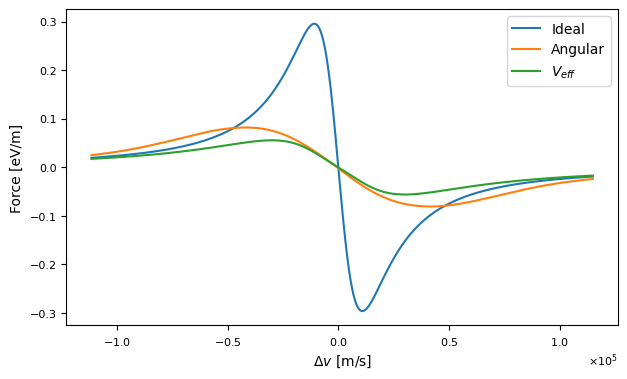

In [85]:
# Create the figure with the specified size
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create the line plots instead of scatter
ax.plot(v_diff_sorted, force_0_sorted, label='Ideal')
ax.plot(v_diff_sorted, force_sorted, label='Angular')
ax.plot(v_diff_sorted, force_old_sorted, label='$V_{eff}$')

# Set labels with proper font sizes
ax.set_xlabel('$\\Delta v$ [m/s]', fontsize=label_fontsize)
ax.set_ylabel('Force [eV/m]', fontsize=label_fontsize)

# Set the legend with custom font size
ax.legend(fontsize=legend_fontsize)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Set x-axis tick labels to scientific notation but prevent the large scale factor from appearing
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

# Adjust the position of the scientific notation label
ax.get_xaxis().get_offset_text().set_fontsize(tick_fontsize)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot to a file
plt.savefig('angle_imperfection_force.png', dpi=300)

# Show the plot
plt.show()
